# Test Fuctions

## Set up

In [32]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [33]:
import os

# TODO: Fill in the Google Drive path where you uploaded the lab materials
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Lab materials 01-20210104'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'CV_CW' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['CW_Dataset.zip', 'Project', 'README.md', 'Orestis_Charalambous_CV_Project.pdf']


In [34]:

# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it
!yes|unzip -q CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CW_Dataset.zip

replace test/test_0288_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_0828_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_1505_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_0317_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_1055_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_0647_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_2986_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_1923_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_0591_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_2326_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_1383_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_2676_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_3064_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_2819_aligned.jpg? [y

## Installing and Importing necessary libraries

In [35]:
!pip install opencv-python==4.4.0.46

In [36]:
!pip install facenet-pytorch

In [37]:
import cv2
import time
from PIL import Image
from facenet_pytorch import MTCNN
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, train_test_split, learning_curve
from skimage import img_as_ubyte, io, color
from sklearn.cluster import MiniBatchKMeans
from skimage.feature import hog
from skimage import data, exposure
from sklearn import svm
import numpy as np
from collections import Counter
from sklearn.neural_network import MLPClassifier
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import seaborn as sns
import random
import pickle

from scipy.stats import zscore
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import recall_score, roc_auc_score, precision_score, roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set()
rc = {'axes.facecolor': 'white',
      'axes.edgecolor': 'black',
      'axes.labelsize' : '24',
      'axes.titlesize' : '24',
      'font.family': ['serif'], 
      'grid.color': 'gainsboro',
      'xtick.color': '#333F4B',
      'font.size': '20',
      'ytick.color': '#333F4B',
      'grid.linestyle': '-', 
      'patch.edgecolor': 'none',
      'axes.grid' : 'False'
      }
sns.set_style(rc=rc)
sns.set_context("notebook", font_scale=1.5)
colors = ['dimgray','mediumaquamarine', 'goldenrod',  'plum' , 'indianred', 'cornflowerblue', 'lightsalmon' ]

**Writing on txt files as the same name on the image folders**

In [38]:
fin = open("/content/labels/list_label_test.txt", "rt") #read input file
data = fin.read()                                       #read file contents to string
data = data.replace('.jpg', '_aligned.jpg')             #replace all occurrences of the required string
fin.close()                                             #close the input file
fin = open("/content/labels/list_label_test.txt", "wt") #open the input file in write mode
fin.write(data)                                         #overrite the input file with the resulting data
fin.close()                                             #close the file

In [39]:
fin = open("/content/labels/list_label_train.txt", "rt") #read input file
data = fin.read()                                        #read file contents to string
data = data.replace('.jpg', '_aligned.jpg')              #replace all occurrences of the required string
fin.close()                                              #close the input file
fin = open("/content/labels/list_label_train.txt", "wt") #open the input file in write mode
fin.write(data)                                          #overrite the input file with the resulting data
fin.close()                                              #close the file

**Importing python scripts**

In [40]:
%cd /content/drive/MyDrive/CV_CW/Project
from dataset import DatasetLoader
from model import Net

/content/drive/MyDrive/CV_CW/Project


## Test function for best CNN model

In [41]:
# Paths
PATH_TO_DATASET_DIR = "/content"   # Path for unzipped Dataset
PATH_TO_CLASSES_TXT = "/content/drive/MyDrive/CV_CW/Project/configs/classes.txt"

# Parameters
IMAGE_SIZE = (100, 100)
BATCH_SIZE = 64
dict_img = {"0": "Surprise", "1": "Fear", "2": "Disgust", "3": "Happiness", "4": "Sadness", "5": "Anger",
            "6": "Neutral"}
NUM_CLASSES = 7
image_size = IMAGE_SIZE
use_gpu = torch.cuda.is_available()


def EmotionRecognition_CNN(dataset_path, checkpoint_path, classes):
    model = Net(num_classes=classes)   # Load model

    if use_gpu:
        model = model.cuda()

    model.load_state_dict(checkpoint_path['state'])
    print("Trained model is loaded !")

    transform = {
        "test": transforms.Compose([transforms.Resize(image_size), transforms.PILToTensor()])
    }

    test_dataset = DatasetLoader(dataset_path, transform, mode="test")
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        num_workers=1,
        pin_memory=True,
        shuffle=True
    )

    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(4 * 4, 4))

    dataiter = iter(test_loader)
    images, targets = dataiter.next()

    # Plot images
    for i in range(4):
        frame_orig, frame = images[i], images[i]
        gt = targets[i]

        if use_gpu:
            frame = frame.cuda()

        frame = frame.view(1, 3, image_size[0], image_size[1])
        with torch.no_grad():
            logps = model(frame)

        # post process 
        ps = torch.exp(logps)
        probab = list(ps.cpu()[0])
        predicted_label = probab.index(max(probab))
        xxx = dict_img["{}".format(gt)]
        yyy = dict_img["{}".format(predicted_label)]
        title = f"Label: {xxx} \n Prediction: {yyy}"
        frame_orig = frame_orig / 2 + 0.5  # Unnormalize
        frame_orig = frame_orig.numpy()
        axes[i].imshow(np.transpose(frame_orig, (1, 2, 0)), interpolation='nearest', aspect='auto')
        axes[i].title.set_text(title)
    plt.show()

Trained model is loaded !
data_file: /content
total testing images: 3068


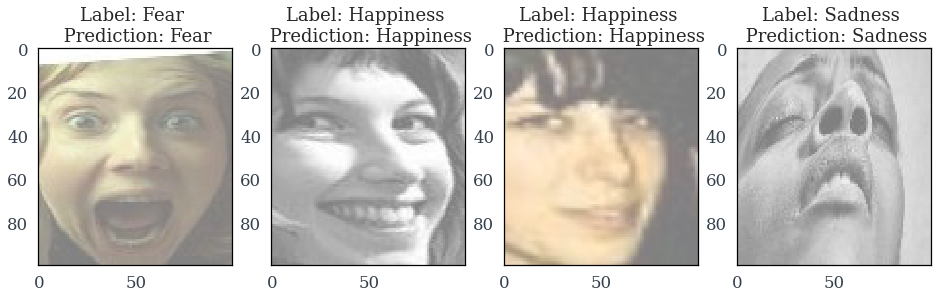

In [42]:
# Load model in torch
tmp = torch.load("/content/drive/MyDrive/CV_CW/Project/Models/CNN_Hyperparameters_trained.tar")

EmotionRecognition_CNN(PATH_TO_DATASET_DIR, tmp, NUM_CLASSES)

## Test Function for SVM and MLP models

In [43]:
%cd /content/

/content


In [44]:
dict_img = {"1": "Surprise", "2": "Fear", "3": "Disgust", "4": "Happiness", "5": "Sadness", "6": "Anger",
            "7": "Neutral"}

def EmotionRecognition_SVM_MLP(model_path, model_type):

  with open(model_path, "rb") as f:
    model_trained = pickle.load(f)

  def import_data(path):
    files = [file for file in sorted(os.listdir(path)) if file.endswith('.jpg')]
    images = [cv2.imread(os.path.join(path, file)) for file in files]
    f = open("labels/list_label_" + path + ".txt", "r")
    labels = [row.split(' ')[1][0] for row in f]
  
    return images, labels

  X_train, y_train = import_data("train")
  X_test, y_test = import_data("test")

  if model_type == "SVM_SIFT":
    sift = cv2.SIFT_create()
    des_list = []
    y_train_list = []

    for i in range(len(X_train)):
        # Identify keypoints and extract descriptors with SIFT
        img = img_as_ubyte(color.rgb2gray(X_train[i]))
        kp, des = sift.detectAndCompute(img, None)
        # Append list of descriptors and label to respective lists
        if des is not None:
            des_list.append(des)
            y_train_list.append(y_train[i])
    des_array = np.vstack(des_list)
    hist_list = []
    k = len(np.unique(y_train)) * 10
    batch_size = des_array.shape[0] // 4
    kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size).fit(des_array)
    for i in range(len(X_test)):
        img = img_as_ubyte(color.rgb2gray(X_test[i]))
        kp, des = sift.detectAndCompute(img, None)

        if des is not None:
            hist = np.zeros(k)

            idx = kmeans.predict(des)

            for j in idx:
                hist[j] = hist[j] + (1 / len(des))

            # hist = scale.transform(hist.reshape(1, -1))
            hist_list.append(hist)

        else:
            hist_list.append(None)

    # Remove potential cases of images with no descriptors
    idx_not_empty = [i for i, x in enumerate(hist_list) if x is not None]
    hist_list = [hist_list[i] for i in idx_not_empty]
    y_test = [y_test[i] for i in idx_not_empty]
    hist_array = np.vstack(hist_list)
    predicted = model_trained.predict(hist_array).tolist()

  if model_type == "SVM_HOG" or model_type == "MLP_HOG":
    hist_list2 = []

    for i in range(len(X_test)):
        img = img_as_ubyte(color.rgb2gray(X_test[i]))
        fd, hog_image = hog( img, orientations=8, pixels_per_cell=(16, 16),  cells_per_block=(1, 1), visualize=True)
        
        
        hist_list2.append(fd)

    hist_array = np.vstack(hist_list2)
    predicted = model_trained.predict(hist_list2)
    
  print("\n------------------Classification Report---------------------")
  print()
  print(classification_report(y_test,predicted))
  print("\n------------------------------------------------------------")
  
  plt.figure(figsize=(14, 11), linewidth=1)

  for i in range(1,5):
    
    x = random.randint(1,100)
    lbl = dict_img["{}".format(y_test[x])]
    preds = dict_img["{}".format(predicted[x])]
    plt.subplot(1,4,i)
    plt.imshow(X_test[x])
    plt.title(f'Label: {lbl} \n Prediction: {preds}')

  plt.tight_layout()
  plt.show

**Choose and subsitute models accordingly**

Might take a few seconds to run

In [45]:
### Model Paths ###
# "SVM_SIFT" = "/content/drive/MyDrive/CV_CW/Project/Models/SVM_SIFT_with_hyperparameters_trained.pkl"
# "SVM_HOG" = "/content/drive/MyDrive/CV_CW/Project/Models/SVM_HOG_with_hyperparameters_trained.pkl"
# "MLP_HOG" = "/content/drive/MyDrive/CV_CW/Project/Models/MLP_with_hyperparameters_trained.pkl"


------------------Classification Report---------------------

              precision    recall  f1-score   support

           1       0.63      0.51      0.57       329
           2       0.91      0.14      0.24        74
           3       0.55      0.04      0.07       160
           4       0.72      0.88      0.79      1185
           5       0.52      0.44      0.48       478
           6       0.68      0.31      0.42       162
           7       0.57      0.71      0.63       680

    accuracy                           0.64      3068
   macro avg       0.65      0.43      0.46      3068
weighted avg       0.64      0.64      0.61      3068


------------------------------------------------------------


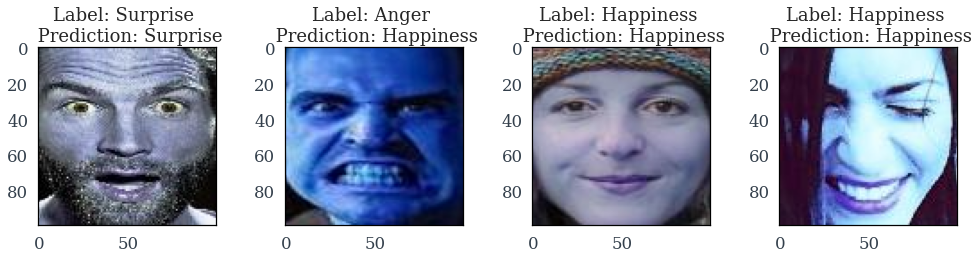

In [46]:
EmotionRecognition_SVM_MLP("/content/drive/MyDrive/CV_CW/Project/Models/SVM_HOG_with_hyperparameters_trained.pkl", "SVM_HOG")